# Семинар 1 — Оценка производительности LLM: Latency, Throughput и оптимизация

-----

### **Цель семинара**

На этом семинаре мы научимся профессионально оценивать производительность языковых моделей. Мы измерим **latency** и **throughput**, проанализируем потребление памяти, исследуем влияние размера батча и научимся оптимизировать стоимость использования LLM в production.

### **Что мы изучим:**
1. Методы измерения latency (TTFT, TBT, e2e latency)
2. Профилирование throughput
3. Анализ потребления GPU/RAM памяти
4. Сравним библиотеки для инференса transformers и llama.cpp
5. Сравним метрики для разного квантования и гиперпараметров

-----

### **0. Установка и импорт библиотек**


In [ ]:
!pip install bitsandbytes

In [ ]:
# Проверим GPU
!nvidia-smi

Thu Sep 25 22:24:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   71C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Посмотрим на версию cuda

In [ ]:
import torch, os
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))

# Фиксируем потоки для воспроизводимости
os.environ["OMP_NUM_THREADS"] = str(max(1, os.cpu_count()//2))
torch.set_num_threads(max(1, os.cpu_count()//2))


Torch: 2.8.0+cu126
CUDA available: True
CUDA device: Tesla T4


### Собираем llama.cpp с CUDA.
Простая установка через менеджер пакетов pip установит версию для работы с cpu! Требуется сборка с CMAKE и ключом DGGML_CUDA=on

Если у вас cuda 12.1 есть уже готовые [сборки](https://abetlen.github.io/llama-cpp-python/whl/cu121).

Обратите внимание, что flash attention в llama.cpp требует дополнительного флага при сборке

## P.S. Уважаемые семинаристы, процесс сборки длительный - запускайте его за полчаса до семинара

In [ ]:
!pip uninstall -y llama-cpp-python
!CMAKE_ARGS="-DGGML_CUDA=on" pip install --no-cache-dir --force-reinstall -U llama-cpp-python


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 MB 106.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 229.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 197.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.9/134.9 kB 259.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 192.6 MB/s eta 0:00:00
  Created wheel for llama-cpp-python: filename=llama_cpp_python-0.3.16-cp312-cp312-linux_x86_64.whl size=52139463 sha256=ec6cbd84ecfdd2a614e351a4c9e4b62bb38a922ebcea2ed3d72b857ea8fbd900
  Stored in directory: /tmp/pip-ephem-wheel-cache-eyaaxkyk/wheels/90/82/ab/8784ee3fb99ddb07fd36a679ddbe63122cc07718f6c1eb3be8
Successfully built llama-cpp

### После установки требуется перезапуск среды! Уведомления об этом ни на одной платформе не будет приходить, это особенность llama.cpp

llama-cpp-python позволяет поднимать модели прямо в коде. На своем железе есть возможность поднять сервер на C++, однако вы будете терять на обращении по API, однако для продакшена в компании это потребуется

In [ ]:
import llama_cpp
print("llama_cpp:", llama_cpp.__version__)

llama_cpp: 0.3.16


-----

### **1. Основные метрики производительности LLM**

Перед началом практики давайте разберём ключевые метрики:

#### **Latency метрики:**
- **Time To First Token (TTFT)** — время до генерации первого токена
- **Time Between Tokens (TBT)** — среднее время между токенами  
- **End-to-End Latency** — полное время от запроса до ответа

#### **Throughput метрики:**
- **Tokens per second** — скорость генерации
- **Requests per second** — количество обработанных запросов
- **Batch efficiency** — эффективность батчинга

#### **Resource метрики:**
- **GPU Memory Usage** — использование видеопамяти
- **GPU Utilization** — утилизация вычислительных ресурсов
- **Cost per 1K tokens** — стоимость обработки

In [ ]:
import os, time, json, math, statistics as stats, gc
from dataclasses import dataclass, asdict
from typing import List, Dict, Any
import numpy as np, pandas as pd
import torch
from tqdm.auto import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

@dataclass
class RunRow:
    runtime: str
    model: str
    variant: str
    prompt_len: int
    gen_len: int
    TTFT_ms: float
    E2E_ms: float
    toks_per_s: float
    prefill_tps: float
    peak_vram_mb: float
    params: Dict[str, Any]

def _gpu_peak_mb():
    if torch.cuda.is_available():
        torch.cuda.synchronize()
        peak = torch.cuda.max_memory_allocated() / (1024**2)
        torch.cuda.reset_peak_memory_stats()
        return float(peak)
    return 0.0

def _warmup_cuda():
    if torch.cuda.is_available():
        torch.cuda.synchronize()


-----

### **2. Настройка бенчмарка**

Создадим бенчмаркинг LLM для transformers и llama_cpp

In [ ]:
from threading import Thread
from transformers import AutoTokenizer, AutoModelForCausalLM, TextIteratorStreamer, BitsAndBytesConfig

def load_hf_model(model_id: str, fp16=True, load_4bit=False, **extra_kwargs):
    qcfg = None
    dtype = torch.float16 if fp16 else torch.float32
    kwargs = dict(device_map="auto", torch_dtype=dtype)
    if load_4bit:
        # Официальная схема 4-бит (NF4 и др.) через bitsandbytes
        # https://huggingface.co/docs/transformers/en/quantization/bitsandbytes
        qcfg = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4")
        kwargs.update(dict(quantization_config=qcfg))
        # dtype="auto" допустим, но мы оставим fp16 для ясности
    kwargs.update(extra_kwargs)
    tok = AutoTokenizer.from_pretrained(model_id, use_fast=True)
    mdl = AutoModelForCausalLM.from_pretrained(model_id, **kwargs).eval()
    return tok, mdl

@torch.inference_mode()
def bench_hf(model_id: str, prompt: str, max_new_tokens=128, fp16=True, load_4bit=False, **gen_kwargs) -> RunRow:
    tok, mdl = load_hf_model(model_id, fp16=fp16, load_4bit=load_4bit)
    inputs = tok(prompt, return_tensors="pt").to(mdl.device)

    # Стриминг для измерения TTFT
    streamer = TextIteratorStreamer(tok, skip_prompt=True, skip_special_tokens=True)  # docs: streaming guide
    # https://huggingface.co/docs/transformers/en/main_classes/text_generation
    gen_args = dict(**inputs, max_new_tokens=max_new_tokens, do_sample=False, streamer=streamer)
    gen_args.update(gen_kwargs)

    # Подготовка измерений
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.synchronize()

    t0 = time.perf_counter(); t_first = None; out_toks = 0

    th = Thread(target=mdl.generate, kwargs=gen_args)
    th.start()
    for piece in streamer:
        if t_first is None:
            t_first = time.perf_counter()
        out_toks += max(1, len(tok.encode(piece)))
    th.join()
    t1 = time.perf_counter()

    if torch.cuda.is_available():
        torch.cuda.synchronize()

    TTFT_ms = (t_first - t0)*1000 if t_first else (t1 - t0)*1000
    E2E_ms  = (t1 - t0)*1000
    toks_per_s = out_toks / max((t1 - (t_first or t0)), 1e-6)
    prefill_tps = int(inputs["input_ids"].shape[-1]) / max((t_first or t1) - t0, 1e-6)
    peak_vram = _gpu_peak_mb()

    row = RunRow(
        runtime="transformers", model=model_id, variant=("4bit" if load_4bit else ("fp16" if fp16 else "fp32")),
        prompt_len=int(inputs["input_ids"].shape[-1]), gen_len=out_toks,
        TTFT_ms=TTFT_ms, E2E_ms=E2E_ms, toks_per_s=toks_per_s, prefill_tps=prefill_tps,
        peak_vram_mb=peak_vram, params=dict(max_new_tokens=max_new_tokens, **gen_kwargs)
    )

    del tok, mdl, inputs
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    return row


In [ ]:
from llama_cpp import Llama

def bench_llamacpp(gguf_path: str, prompt: str, max_new_tokens=128, n_gpu_layers=999, n_ctx=4096, **gen_kwargs) -> RunRow:
    # В Colab с T4 — cuBLAS активен (ставили с CUDA)
    llm = Llama(model_path=gguf_path, n_gpu_layers=n_gpu_layers, n_ctx=n_ctx, logits_all=False, verbose=False)

    # Стримим для TTFT (create_completion(..., stream=True))
    # Библиотека печатает подробные timings, но мы замерим вручную для сопоставимости
    if torch.cuda.is_available(): torch.cuda.synchronize()
    t0 = time.perf_counter(); t_first=None; out_toks=0

    for chunk in llm.create_completion(prompt=prompt, max_tokens=max_new_tokens, stream=True, **gen_kwargs):
        if t_first is None:
            t_first = time.perf_counter()
        out_toks += 1

    if torch.cuda.is_available(): torch.cuda.synchronize()
    t1 = time.perf_counter()

    prompt_len = len(llm.tokenize(prompt.encode()))
    TTFT_ms = (t_first - t0)*1000 if t_first else (t1 - t0)*1000
    E2E_ms  = (t1 - t0)*1000
    toks_per_s = out_toks / max((t1 - (t_first or t0)), 1e-6)
    prefill_tps = prompt_len / max((t_first or t1) - t0, 1e-6)

    # llama.cpp не экспонирует VRAM напрямую; для единообразия берём CUDA пик
    peak_vram = _gpu_peak_mb()

    row = RunRow(
        runtime="llama.cpp", model=os.path.basename(gguf_path), variant="gguf",
        prompt_len=prompt_len, gen_len=out_toks,
        TTFT_ms=TTFT_ms, E2E_ms=E2E_ms, toks_per_s=toks_per_s, prefill_tps=prefill_tps,
        peak_vram_mb=peak_vram, params=dict(max_new_tokens=max_new_tokens, n_gpu_layers=n_gpu_layers, n_ctx=n_ctx, **gen_kwargs)
    )
    del llm
    gc.collect()
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    return row


-----

### **3. Подготовка данных и моделей**

Возьмем сопоставимые модели Qwen3 и phi-4 для разных библиотек. Также посмотрим на квантованные модели

In [ ]:
PROMPTS = [
    "Назови 3 риска внедрения чат-бота в банке, по пунктам.",
    "Объясни разницу между TTFT, E2E latency и tokens-per-second в инференсе LLM.",
    "Краткое саммери: большие модели vs маленькие модели для продакшн-задач (3-4 предложения).",
    "Перефразируй: гибридный поиск сочетает BM25 и dense retrieval."
]

In [ ]:
MODELS = {
    "qwen3_4b_instruct_2507": {
        "hf_id": "Qwen/Qwen3-4B-Instruct-2507",
        # предпочитаемый GGUF (можно заменить на официальный Qwen/Qwen3-4B-GGUF)
        "gguf": {
            "repo_id": "Qwen/Qwen3-4B-GGUF",
            "filename": "Qwen3-4B-Q4_K_M.gguf"
        }
    },
    "phi4_mini_instruct": {
        "hf_id": "microsoft/Phi-4-mini-instruct",
        "gguf": {
            "repo_id": "bartowski/microsoft_Phi-4-mini-instruct-GGUF",
            "filename": "microsoft_Phi-4-mini-instruct-Q4_K_M.gguf"
        }
    }
}

In [ ]:
# Загрузка GGUF через Hugging Face Hub для llama_cpp
from huggingface_hub import hf_hub_download

def get_gguf_local(repo_id: str, filename: str) -> str:
    path = hf_hub_download(repo_id=repo_id, filename=filename, local_dir="/content/gguf", local_dir_use_symlinks=False)
    return path


-----

### **4. Запуск бенчмарка**

Теперь протестируем модели с разными параметрами и библиотеками.

In [ ]:
# === Консолидированный прогон: HF (fp16), HF (4-bit), llama.cpp (GGUF) для каждой модели из MODELS ===
results: List[RunRow] = []

GEN_BASE = dict(temperature=0.0, top_k=0, top_p=1.0)  # фиксируем декодинг для честного сравнения

for key, spec in MODELS.items():
    hf_id = spec["hf_id"]

    # 1) HF FP16
    row_fp16 = bench_hf(hf_id, PROMPTS[0], max_new_tokens=128, fp16=True, load_4bit=False, **GEN_BASE)
    row_fp16.model = f"{key} (HF fp16)"
    results.append(row_fp16)
    print("[HF fp16]", hf_id, "→ TTFT={:.0f}ms  E2E={:.0f}ms  tok/s={:.1f}".format(
        row_fp16.TTFT_ms, row_fp16.E2E_ms, row_fp16.toks_per_s))

    # 2) HF 4-bit (тот же чекпоинт, другая загрузка)
    row_4b = bench_hf(hf_id, PROMPTS[0], max_new_tokens=128, fp16=True, load_4bit=True, **GEN_BASE)
    row_4b.model = f"{key} (HF 4bit)"
    results.append(row_4b)
    print("[HF 4bit]", hf_id, "→ TTFT={:.0f}ms  E2E={:.0f}ms  tok/s={:.1f}".format(
        row_4b.TTFT_ms, row_4b.E2E_ms, row_4b.toks_per_s))

    # 3) llama.cpp GGUF (тот же чекпоинт в GGUF)
    repo = spec["gguf"]["repo_id"]; fname = spec["gguf"]["filename"]
    gguf_path = get_gguf_local(repo, fname)
    row_gguf = bench_llamacpp(gguf_path, PROMPTS[0], max_new_tokens=128, n_gpu_layers=999)
    row_gguf.model = f"{key} (llama.cpp {fname})"
    results.append(row_gguf)
    print("[llama.cpp gguf]", fname, "→ TTFT={:.0f}ms  E2E={:.0f}ms  tok/s={:.1f}".format(
        row_gguf.TTFT_ms, row_gguf.E2E_ms, row_gguf.toks_per_s))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/99.6M [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[HF fp16] Qwen/Qwen3-4B-Instruct-2507 → TTFT=1305ms  E2E=9444ms  tok/s=32.8


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

[HF 4bit] Qwen/Qwen3-4B-Instruct-2507 → TTFT=457ms  E2E=11546ms  tok/s=24.1


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:982: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


Qwen3-4B-Q4_K_M.gguf:   0%|          | 0.00/2.50G [00:00<?, ?B/s]

llama_context: n_ctx_per_seq (4096) < n_ctx_train (40960) -- the full capacity of the model will not be utilized


[llama.cpp gguf] Qwen3-4B-Q4_K_M.gguf → TTFT=284ms  E2E=2854ms  tok/s=50.2


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/15.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.77G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

[HF fp16] microsoft/Phi-4-mini-instruct → TTFT=221ms  E2E=6877ms  tok/s=48.1


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

[HF 4bit] microsoft/Phi-4-mini-instruct → TTFT=354ms  E2E=8686ms  tok/s=36.8


llama_context: n_ctx_per_seq (4096) < n_ctx_train (131072) -- the full capacity of the model will not be utilized


[llama.cpp gguf] microsoft_Phi-4-mini-instruct-Q4_K_M.gguf → TTFT=95ms  E2E=2623ms  tok/s=51.0


-----

### **5. Тестирование различный параметров инференса**

Переберём гиперпараметры temperature, top_k, top_p

In [ ]:
# === перебор для одной и той же модели (HF fp16 vs HF 4-bit) ===
SWEEP_MODEL_KEY = "qwen3_4b_instruct_2507"
hf_id = MODELS[SWEEP_MODEL_KEY]["hf_id"]

SWEEP = [
    dict(temperature=0.0, top_k=0,   top_p=1.0),   # детерминированно
    dict(temperature=0.7, top_k=40,  top_p=0.95),  # классический сэмплинг
    dict(temperature=0.3, top_k=50,  top_p=0.90),  # компромисс
]

for cfg in SWEEP:
    for p in PROMPTS:
        r1 = bench_hf(hf_id, p, max_new_tokens=128, fp16=True,  load_4bit=False, **cfg)
        r1.model = f"{SWEEP_MODEL_KEY} (HF fp16 sweep)"
        r1.params["sweep"] = True
        results.append(r1)
        print("[fp16 sweep]", cfg, "→ TTFT={:.0f}  E2E={:.0f}  tok/s={:.1f}".format(r1.TTFT_ms, r1.E2E_ms, r1.toks_per_s))

        r2 = bench_hf(hf_id, p, max_new_tokens=128, fp16=True,  load_4bit=True,  **cfg)
        r2.model = f"{SWEEP_MODEL_KEY} (HF 4bit sweep)"
        r2.params["sweep"] = True
        results.append(r2)
        print("[4bit sweep]", cfg, "→ TTFT={:.0f}  E2E={:.0f}  tok/s={:.1f}".format(r2.TTFT_ms, r2.E2E_ms, r2.toks_per_s))


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

[fp16 sweep] {'temperature': 0.0, 'top_k': 0, 'top_p': 1.0} → TTFT=147  E2E=8302  tok/s=32.7


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

[4bit sweep] {'temperature': 0.0, 'top_k': 0, 'top_p': 1.0} → TTFT=400  E2E=11709  tok/s=23.6


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

[fp16 sweep] {'temperature': 0.0, 'top_k': 0, 'top_p': 1.0} → TTFT=136  E2E=8065  tok/s=34.2


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

[4bit sweep] {'temperature': 0.0, 'top_k': 0, 'top_p': 1.0} → TTFT=415  E2E=11723  tok/s=24.8


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

[fp16 sweep] {'temperature': 0.0, 'top_k': 0, 'top_p': 1.0} → TTFT=155  E2E=7854  tok/s=39.0


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

[4bit sweep] {'temperature': 0.0, 'top_k': 0, 'top_p': 1.0} → TTFT=418  E2E=11839  tok/s=25.1


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

[fp16 sweep] {'temperature': 0.0, 'top_k': 0, 'top_p': 1.0} → TTFT=141  E2E=7517  tok/s=39.3


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

[4bit sweep] {'temperature': 0.0, 'top_k': 0, 'top_p': 1.0} → TTFT=398  E2E=11755  tok/s=23.3


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[fp16 sweep] {'temperature': 0.7, 'top_k': 40, 'top_p': 0.95} → TTFT=136  E2E=7623  tok/s=35.7


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

[4bit sweep] {'temperature': 0.7, 'top_k': 40, 'top_p': 0.95} → TTFT=398  E2E=11889  tok/s=23.2


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

[fp16 sweep] {'temperature': 0.7, 'top_k': 40, 'top_p': 0.95} → TTFT=139  E2E=8098  tok/s=34.1


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

[4bit sweep] {'temperature': 0.7, 'top_k': 40, 'top_p': 0.95} → TTFT=434  E2E=11548  tok/s=25.2


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

[fp16 sweep] {'temperature': 0.7, 'top_k': 40, 'top_p': 0.95} → TTFT=131  E2E=8096  tok/s=37.7


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

[4bit sweep] {'temperature': 0.7, 'top_k': 40, 'top_p': 0.95} → TTFT=415  E2E=11719  tok/s=25.4


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

[fp16 sweep] {'temperature': 0.7, 'top_k': 40, 'top_p': 0.95} → TTFT=123  E2E=8065  tok/s=36.5


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

[4bit sweep] {'temperature': 0.7, 'top_k': 40, 'top_p': 0.95} → TTFT=407  E2E=11888  tok/s=23.1


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[fp16 sweep] {'temperature': 0.3, 'top_k': 50, 'top_p': 0.9} → TTFT=157  E2E=7665  tok/s=35.6


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

[4bit sweep] {'temperature': 0.3, 'top_k': 50, 'top_p': 0.9} → TTFT=388  E2E=11720  tok/s=23.6


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

[fp16 sweep] {'temperature': 0.3, 'top_k': 50, 'top_p': 0.9} → TTFT=132  E2E=7677  tok/s=35.9


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

[4bit sweep] {'temperature': 0.3, 'top_k': 50, 'top_p': 0.9} → TTFT=410  E2E=11653  tok/s=24.9


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

[fp16 sweep] {'temperature': 0.3, 'top_k': 50, 'top_p': 0.9} → TTFT=129  E2E=8066  tok/s=37.8


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

[4bit sweep] {'temperature': 0.3, 'top_k': 50, 'top_p': 0.9} → TTFT=412  E2E=11723  tok/s=25.4


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

[fp16 sweep] {'temperature': 0.3, 'top_k': 50, 'top_p': 0.9} → TTFT=134  E2E=8098  tok/s=36.4


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

[4bit sweep] {'temperature': 0.3, 'top_k': 50, 'top_p': 0.9} → TTFT=423  E2E=11633  tok/s=23.6


-----

### **6. Визуализация результатов**

Построим графики для анализа производительности. Сохраним данные в датафрейм и csv

Saved: 30 rows


,runtime,model,variant,prompt_len,gen_len,TTFT_ms,E2E_ms,toks_per_s,prefill_tps,peak_vram_mb,params
0,transformers,qwen3_4b_instruct_2507 (HF fp16),fp16,26,267,1305.160158,9444.114385,32.805197,19.920927,7712.764648,"{'max_new_tokens': 128, 'temperature': 0.0, 't..."
1,transformers,qwen3_4b_instruct_2507 (HF 4bit),4bit,26,267,456.761757,11545.871131,24.077678,56.922454,2863.768555,"{'max_new_tokens': 128, 'temperature': 0.0, 't..."
2,llama.cpp,qwen3_4b_instruct_2507 (llama.cpp Qwen3-4B-Q4_...,gguf,26,129,284.480510,2854.070149,50.202569,91.394662,2715.641113,"{'max_new_tokens': 128, 'n_gpu_layers': 999, '..."
3,transformers,phi4_mini_instruct (HF fp16),fp16,19,320,220.835953,6876.945321,48.076133,86.036715,7350.661621,"{'max_new_tokens': 128, 'temperature': 0.0, 't..."
4,transformers,phi4_mini_instruct (HF 4bit),4bit,19,307,354.196565,8685.525192,36.848865,53.642530,3200.624023,"{'max_new_tokens': 128, 'temperature': 0.0, 't..."


/tmp/ipython-input-1301423287.py:39: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=left_pad)                      # чуть больше места слева под 2 строки


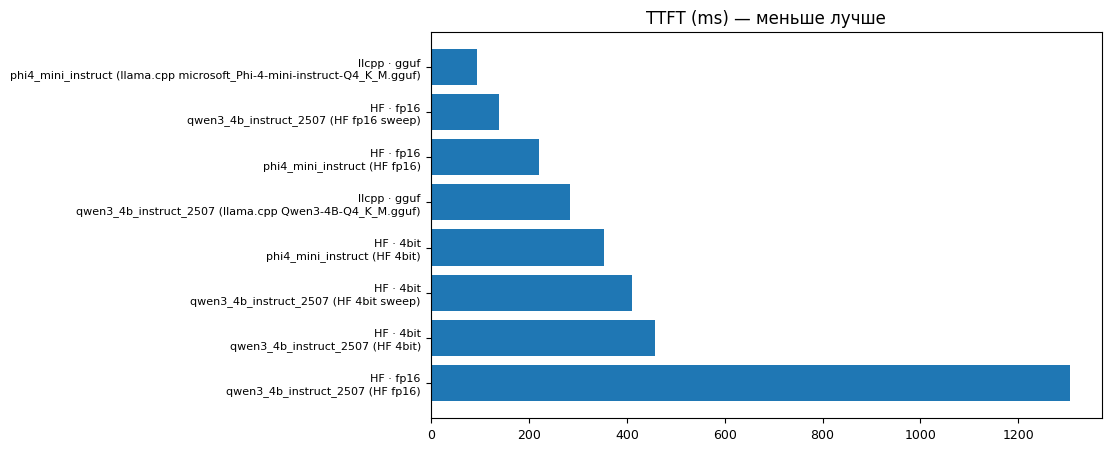

/tmp/ipython-input-1301423287.py:39: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=left_pad)                      # чуть больше места слева под 2 строки


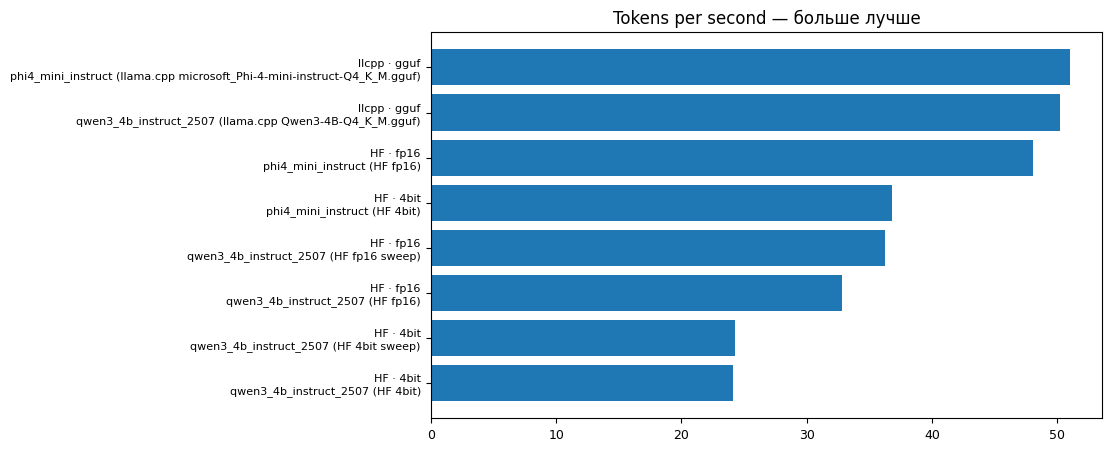

/tmp/ipython-input-1301423287.py:39: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=left_pad)                      # чуть больше места слева под 2 строки


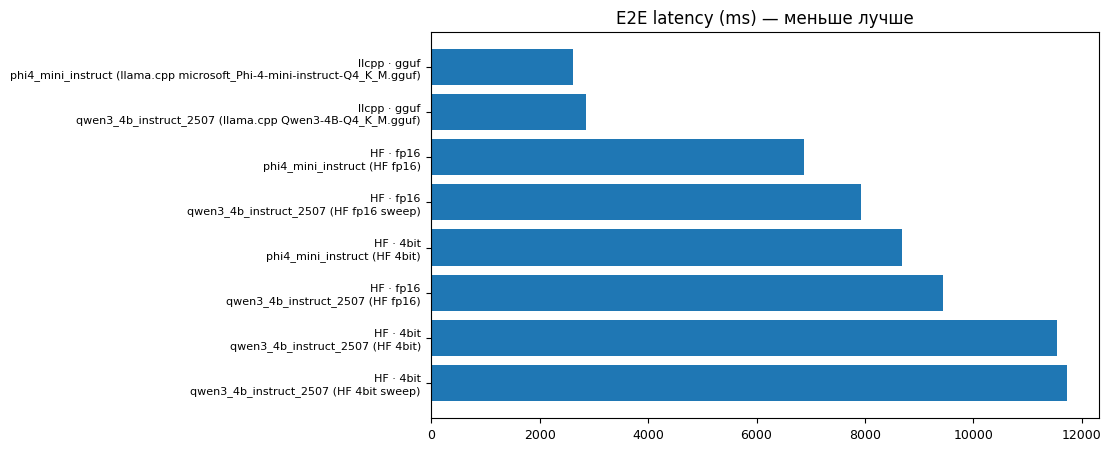

/tmp/ipython-input-1301423287.py:39: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=left_pad)                      # чуть больше места слева под 2 строки


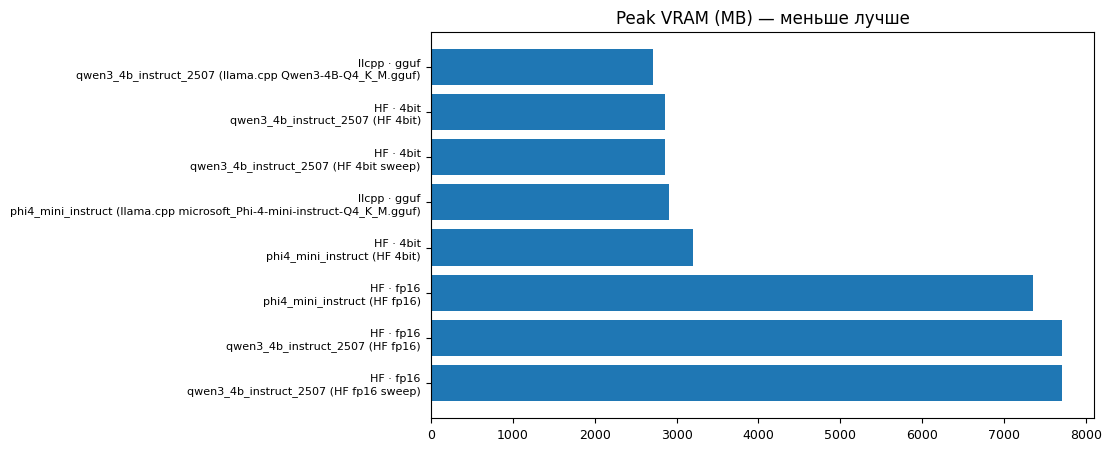

In [ ]:
df = pd.DataFrame([asdict(r) for r in results])
df.to_csv("llm_bench_colab_t4.csv", index=False)
print("Saved:", len(df), "rows")
display(df.head())

# Простые графики (одна метрика на график)
import matplotlib.pyplot as plt
import textwrap

def barplot(metric: str, title: str, *, y_fontsize=8, x_fontsize=9, left_pad=0.40):
    # агрегируем и сортируем: для toks_per_s — по убыванию, для остальных — по возрастанию
    asc = (metric != "toks_per_s")
    s = (df.groupby(["runtime","model","variant"])[metric]
           .mean()
           .sort_values(ascending=asc)
           .reset_index())

    # читаемые короткие подписи в 2 строки без обрезки
    def make_label(runtime, model, variant):
        r = {"transformers": "HF", "llama.cpp": "llcpp"}.get(runtime, runtime)
        tail = model.split("/")[-1]  # только имя чекпойнта
        line1 = f"{r} · {variant}"
        line2 = tail
        return f"{line1}\n{line2}"

    labels = [make_label(r, m, v) for r, m, v in zip(s["runtime"], s["model"], s["variant"])]

    # авто-высота фигуры под число столбиков
    h = max(3.5, 0.55 * len(s))
    fig, ax = plt.subplots(figsize=(11, h), layout="constrained")  # constrained_layout чтобы не было налезаний
    ax.barh(range(len(s)), s[metric].to_numpy())
    ax.set_yticks(range(len(s)), labels=labels)
    ax.invert_yaxis()
    ax.set_title(title)

    # уменьшенный шрифт и небольшой отступ от оси
    ax.tick_params(axis="y", labelsize=y_fontsize, pad=4)   # уменьшить шрифт тиков
    ax.tick_params(axis="x", labelsize=x_fontsize)
    fig.subplots_adjust(left=left_pad)                      # чуть больше места слева под 2 строки

    plt.show()

barplot("TTFT_ms", "TTFT (ms) — меньше лучше")
barplot("toks_per_s", "Tokens per second — больше лучше")
barplot("E2E_ms", "E2E latency (ms) — меньше лучше")
barplot("peak_vram_mb", "Peak VRAM (MB) — меньше лучше")


-----

### **7. Попробуем большую точность для модели phi-4-mini на llama.cpp**


In [ ]:
# 1) Скачиваем F16 GGUF (без кванта)
phi4_f16_path = hf_hub_download(
    repo_id="Mungert/Phi-4-mini-instruct.gguf",   # есть F16 файл в этом репо
    filename="phi-4-mini-f16-q8.gguf",
    local_dir="/content/gguf",
    local_dir_use_symlinks=False,
)
print("Phi-4-mini F16 GGUF:", phi4_f16_path)

# 2) Прогон через llama.cpp (как в твоём цикле)
row = bench_llamacpp(
    phi4_f16_path,
    PROMPTS[0],
    max_new_tokens=128,
    n_gpu_layers=999,   # оффлоад слоёв в GPU (оставь как у тебя)
)
row.model = "phi4_mini_instruct (llama.cpp F16 gguf)"
results.append(row)
print("llama.cpp F16", os.path.basename(phi4_f16_path),
      "TTFT={:.0f} ms  E2E={:.0f} ms  tok/s={:.1f}".format(row.TTFT_ms, row.E2E_ms, row.toks_per_s))


phi-4-mini-f16-q8.gguf:   0%|          | 0.00/4.66G [00:00<?, ?B/s]

Phi-4-mini F16 GGUF: /content/gguf/phi-4-mini-f16-q8.gguf


llama_context: n_ctx_per_seq (4096) < n_ctx_train (131072) -- the full capacity of the model will not be utilized
Exception ignored in: <function LlamaModel.__del__ at 0x793ec1623ce0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/llama_cpp/_internals.py", line 86, in __del__
    self.close()
  File "/usr/local/lib/python3.12/dist-packages/llama_cpp/_internals.py", line 78, in close
    if self.sampler is not None:
       ^^^^^^^^^^^^
AttributeError: 'LlamaModel' object has no attribute 'sampler'
Exception ignored in: <function LlamaModel.__del__ at 0x793ec1623ce0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/llama_cpp/_internals.py", line 86, in __del__
    self.close()
  File "/usr/local/lib/python3.12/dist-packages/llama_cpp/_internals.py", line 78, in close
    if self.sampler is not None:
       ^^^^^^^^^^^^
AttributeError: 'LlamaModel' object has no attribute 'sampler'


llama.cpp F16 phi-4-mini-f16-q8.gguf TTFT=185 ms  E2E=3315 ms  tok/s=41.2


Saved: 31 rows


,runtime,model,variant,prompt_len,gen_len,TTFT_ms,E2E_ms,toks_per_s,prefill_tps,peak_vram_mb,params
0,transformers,qwen3_4b_instruct_2507 (HF fp16),fp16,26,267,1305.160158,9444.114385,32.805197,19.920927,7712.764648,"{'max_new_tokens': 128, 'temperature': 0.0, 't..."
1,transformers,qwen3_4b_instruct_2507 (HF 4bit),4bit,26,267,456.761757,11545.871131,24.077678,56.922454,2863.768555,"{'max_new_tokens': 128, 'temperature': 0.0, 't..."
2,llama.cpp,qwen3_4b_instruct_2507 (llama.cpp Qwen3-4B-Q4_...,gguf,26,129,284.480510,2854.070149,50.202569,91.394662,2715.641113,"{'max_new_tokens': 128, 'n_gpu_layers': 999, '..."
3,transformers,phi4_mini_instruct (HF fp16),fp16,19,320,220.835953,6876.945321,48.076133,86.036715,7350.661621,"{'max_new_tokens': 128, 'temperature': 0.0, 't..."
4,transformers,phi4_mini_instruct (HF 4bit),4bit,19,307,354.196565,8685.525192,36.848865,53.642530,3200.624023,"{'max_new_tokens': 128, 'temperature': 0.0, 't..."


/tmp/ipython-input-1301423287.py:39: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=left_pad)                      # чуть больше места слева под 2 строки


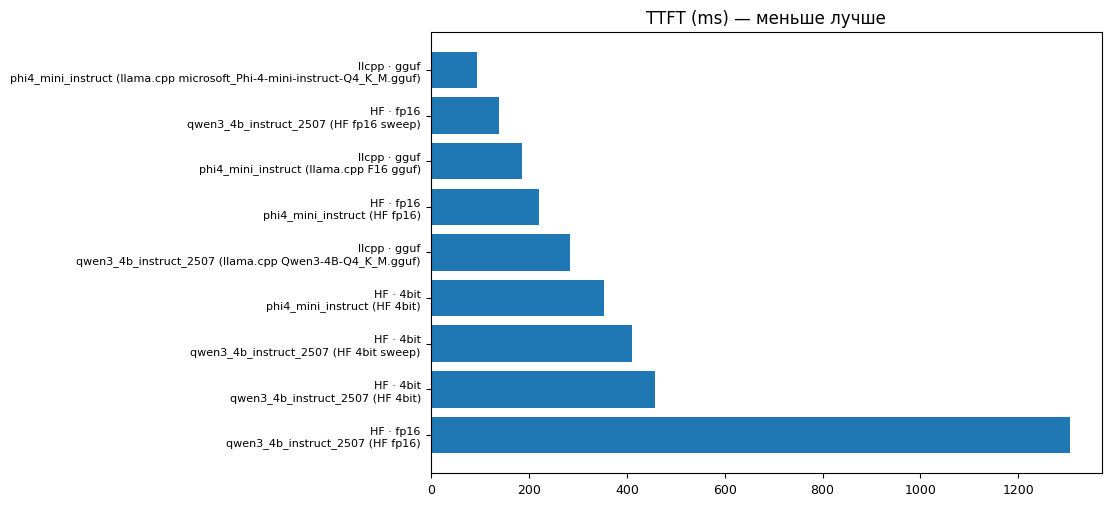

/tmp/ipython-input-1301423287.py:39: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=left_pad)                      # чуть больше места слева под 2 строки


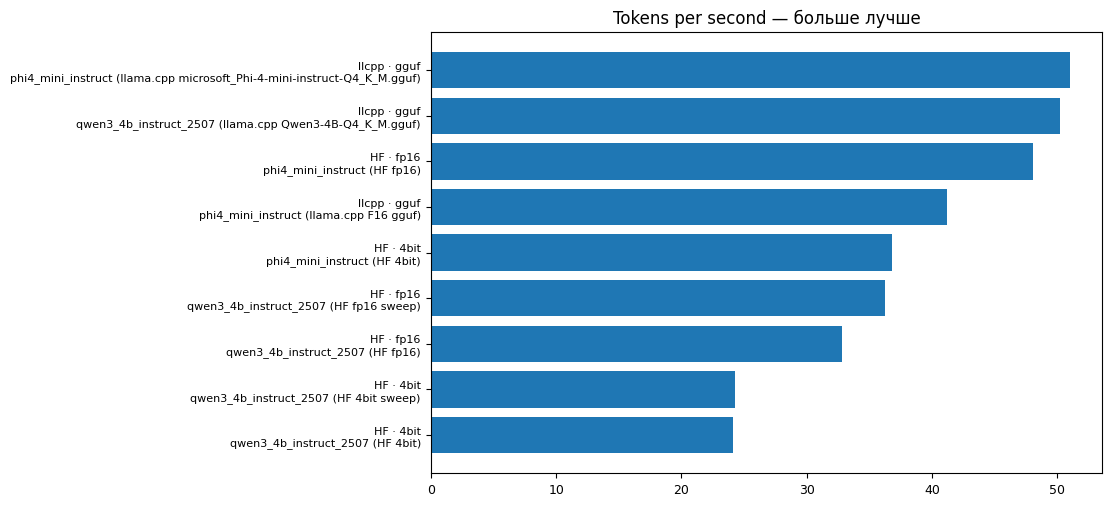

/tmp/ipython-input-1301423287.py:39: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=left_pad)                      # чуть больше места слева под 2 строки


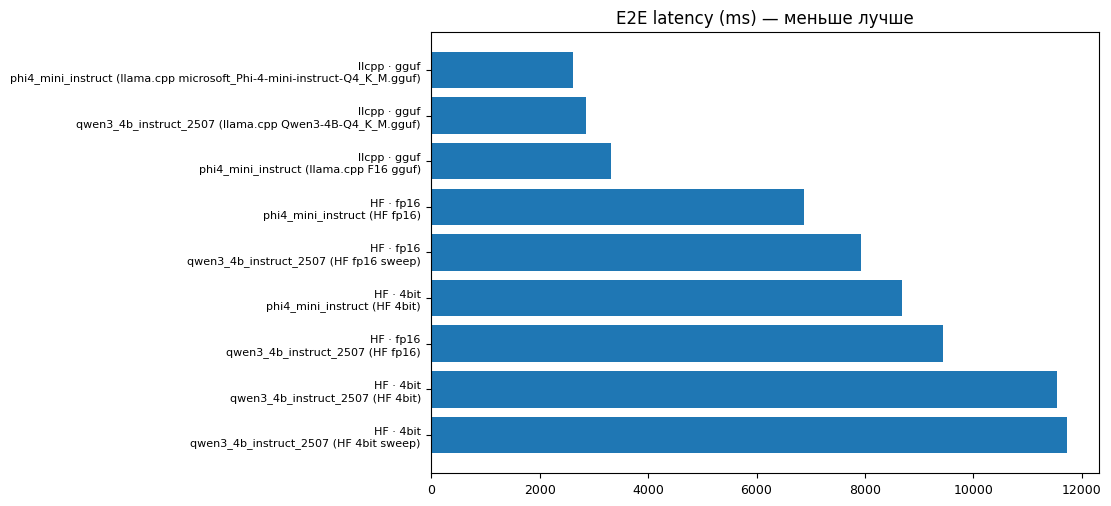

/tmp/ipython-input-1301423287.py:39: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=left_pad)                      # чуть больше места слева под 2 строки


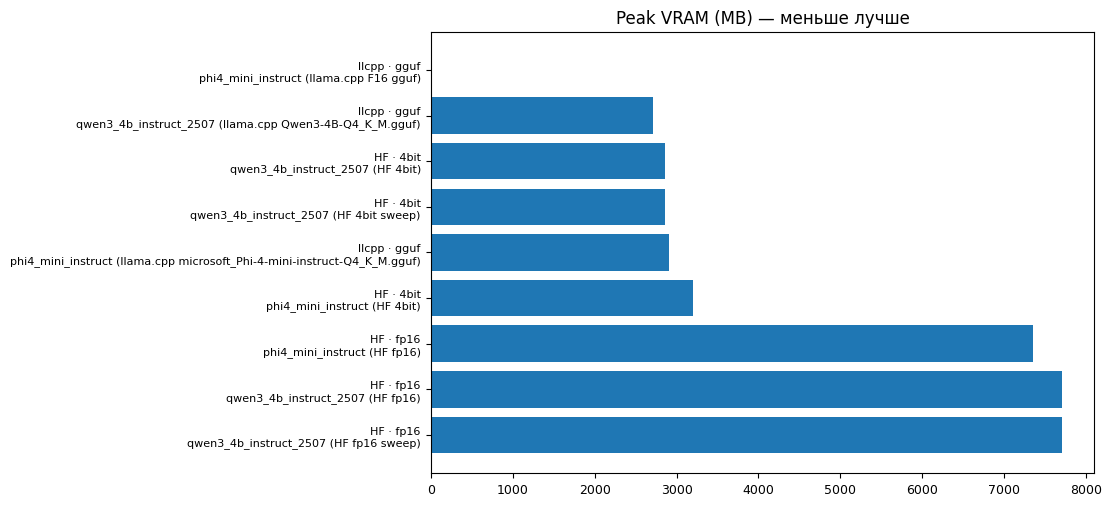

In [ ]:
df = pd.DataFrame([asdict(r) for r in results])
df.to_csv("llm_bench_colab_t4.csv", index=False)
print("Saved:", len(df), "rows")
display(df.head())

# Простые графики (одна метрика на график)
import matplotlib.pyplot as plt
import textwrap

def barplot(metric: str, title: str, *, y_fontsize=8, x_fontsize=9, left_pad=0.40):
    # агрегируем и сортируем: для toks_per_s — по убыванию, для остальных — по возрастанию
    asc = (metric != "toks_per_s")
    s = (df.groupby(["runtime","model","variant"])[metric]
           .mean()
           .sort_values(ascending=asc)
           .reset_index())

    # читаемые короткие подписи в 2 строки без обрезки
    def make_label(runtime, model, variant):
        r = {"transformers": "HF", "llama.cpp": "llcpp"}.get(runtime, runtime)
        tail = model.split("/")[-1]  # только имя чекпойнта
        line1 = f"{r} · {variant}"
        line2 = tail
        return f"{line1}\n{line2}"

    labels = [make_label(r, m, v) for r, m, v in zip(s["runtime"], s["model"], s["variant"])]

    # авто-высота фигуры под число столбиков
    h = max(3.5, 0.55 * len(s))
    fig, ax = plt.subplots(figsize=(11, h), layout="constrained")  # constrained_layout чтобы не было налезаний
    ax.barh(range(len(s)), s[metric].to_numpy())
    ax.set_yticks(range(len(s)), labels=labels)
    ax.invert_yaxis()
    ax.set_title(title)

    # уменьшенный шрифт и небольшой отступ от оси
    ax.tick_params(axis="y", labelsize=y_fontsize, pad=4)   # уменьшить шрифт тиков
    ax.tick_params(axis="x", labelsize=x_fontsize)
    fig.subplots_adjust(left=left_pad)                      # чуть больше места слева под 2 строки

    plt.show()

barplot("TTFT_ms", "TTFT (ms) — меньше лучше")
barplot("toks_per_s", "Tokens per second — больше лучше")
barplot("E2E_ms", "E2E latency (ms) — меньше лучше")
barplot("peak_vram_mb", "Peak VRAM (MB) — меньше лучше")


-----

### **8. Рассмотрим все результаты**

In [ ]:
df

,runtime,model,variant,prompt_len,gen_len,TTFT_ms,E2E_ms,toks_per_s,prefill_tps,peak_vram_mb,params
0,transformers,qwen3_4b_instruct_2507 (HF fp16),fp16,26,267,1305.160158,9444.114385,32.805197,19.920927,7712.764648,"{'max_new_tokens': 128, 'temperature': 0.0, 't..."
1,transformers,qwen3_4b_instruct_2507 (HF 4bit),4bit,26,267,456.761757,11545.871131,24.077678,56.922454,2863.768555,"{'max_new_tokens': 128, 'temperature': 0.0, 't..."
2,llama.cpp,qwen3_4b_instruct_2507 (llama.cpp Qwen3-4B-Q4_...,gguf,26,129,284.480510,2854.070149,50.202569,91.394662,2715.641113,"{'max_new_tokens': 128, 'n_gpu_layers': 999, '..."
3,transformers,phi4_mini_instruct (HF fp16),fp16,19,320,220.835953,6876.945321,48.076133,86.036715,7350.661621,"{'max_new_tokens': 128, 'temperature': 0.0, 't..."
4,transformers,phi4_mini_instruct (HF 4bit),4bit,19,307,354.196565,8685.525192,36.848865,53.642530,3200.624023,"{'max_new_tokens': 128, 'temperature': 0.0, 't..."
5,llama.cpp,phi4_mini_instruct (llama.cpp microsoft_Phi-4-...,gguf,19,129,94.607380,2623.119672,51.018142,200.829999,2909.569824,"{'max_new_tokens': 128, 'n_gpu_layers': 999, '..."
6,transformers,qwen3_4b_instruct_2507 (HF fp16 sweep),fp16,26,267,147.465156,8301.616031,32.744059,176.312837,7712.889648,"{'max_new_tokens': 128, 'temperature': 0.0, 't..."
7,transformers,qwen3_4b_instruct_2507 (HF 4bit sweep),4bit,26,267,399.601307,11709.023315,23.608634,65.064852,2863.768555,"{'max_new_tokens': 128, 'temperature': 0.0, 't..."
8,transformers,qwen3_4b_instruct_2507 (HF fp16 sweep),fp16,27,271,136.464643,8064.996887,34.180349,197.853447,7713.038086,"{'max_new_tokens': 128, 'temperature': 0.0, 't..."
9,transformers,qwen3_4b_instruct_2507 (HF 4bit sweep),4bit,27,280,415.355568,11723.167031,24.761644,65.004546,2863.999023,"{'max_new_tokens': 128, 'temperature': 0.0, 't..."


## Дополнительные ресурсы

**Статьи:**
- [Efficient Memory Management for Large Language Model Serving with PagedAttention](https://arxiv.org/abs/2309.06180)
- [Fast Inference from Transformers via Speculative Decoding](https://arxiv.org/abs/2211.17192)
- [FlashAttention: Fast and Memory-Efficient Exact Attention](https://arxiv.org/abs/2205.14135)

**Библиотеки:**
- [vLLM](https://github.com/vllm-project/vllm) - Высокопроизводительный LLM инференс
- [TGI](https://github.com/huggingface/text-generation-inference) - Продакшн оптимизированный инференс моделей от HuggingFace
- [DeepSpeed-Inference](https://github.com/microsoft/DeepSpeed) - Библиотека для ускорения обучения и инференса от Microsoft
- [TensorRT-LLM](https://github.com/NVIDIA/TensorRT-LLM) - Оптимизация инференса от NVIDIA (требует карт с новыми архитектурами)

**Бенчмарки:**
- [LLMPerf](https://github.com/ray-project/llmperf) - Инструмент для оценки производительности LLM API
- [MLPerf Inference](https://mlcommons.org/en/inference-edge/) - Множество индустриальных бенчмарков для разных серверных решений